In [1]:
%matplotlib inline
figsize = (10,3)

# Input Datasets  

In [2]:
import pandas, numpy
pandas.options.display.float_format = '{:,.4f}'.format
data_folder = '../data'
date_format='%Y-%m-%d' #truncate datetimes to dates
id_columns = ["id","company_id","invoice_id","account_id","customer_id"]
id_column_types = dict(zip(id_columns,[str] * len(id_columns)))
invoices = pandas.read_csv(data_folder + '/invoice.csv', na_values='inf', dtype=id_column_types,
                           parse_dates=['invoice_date', 'due_date', 'cleared_date'], date_format=date_format)
payments = pandas.read_csv(data_folder + '/invoice_payments.csv', na_values='inf', dtype=id_column_types,
                           parse_dates=['transaction_date'], date_format=date_format)

## Dataset Definitions & Relationships

We have two input datasets: invoices and their payments.
- Payments are amounts in time, which are directly mapped to companies. 
- Invoices can have multiple payments, but usually only have 1. 

In [3]:
invoices.rename(columns={"id":"invoice_id"}, inplace=True)
invoices.dtypes

invoice_id                          object
due_date                    datetime64[ns]
invoice_date                datetime64[ns]
status                              object
amount_inv                         float64
currency                            object
company_id                          object
customer_id                         object
account_id                          object
cleared_date                datetime64[ns]
root_exchange_rate_value           float64
dtype: object

In [4]:
payments.dtypes

amount                             float64
root_exchange_rate_value           float64
transaction_date            datetime64[ns]
invoice_id                          object
company_id                          object
converted_amount                   float64
dtype: object

In [5]:
#The join key will be invoice_id, so it must be unique (and it is).
invoices.invoice_id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="ids").rename_axis('invoices_per_id')

,ids
invoices_per_id,
1,113085


In [6]:
#all payments are represented in both datasets 
len(set(payments.invoice_id) - set(invoices.invoice_id))

0

In [7]:
#7% of invoices do not have payments yet
len(set(invoices.invoice_id) - set(payments.invoice_id))/invoices.__len__()

0.07127382057744175

In [8]:
#invoices usually have one payment but may have more
payments.invoice_id.value_counts(dropna=False).value_counts(dropna=False, normalize=True)\
.to_frame(name="invoices").rename_axis('payments_per_invoice')

,invoices
payments_per_invoice,
1,0.9419
2,0.0548
3,0.0026
4,0.0006
5,0.0001
6,0.0001
14,0.0000
9,0.0000
8,0.0000


## Entity Definitions & Relationships

- Company: business entity for which Tesorio is forecasting cash collected. There are only two. Each company collects using multiple currencies from multiple customers. 
- Account: **In this limited dataset, accounts and companies are synonymous, so we ignore accounts.**  
- Customer: metadata about an invoice which is specific to each company. Each customer can have multiple currencies.

In [9]:
invoices.groupby("company_id")[["customer_id","currency"]].nunique()

,customer_id,currency
company_id,,
114,4509,15
14,546,13


In [10]:
invoices.groupby("customer_id").company_id.nunique().value_counts()\
.to_frame(name='customers').rename_axis('companies_per_customer')

,customers
companies_per_customer,
1,5055


In [11]:
invoices.groupby(["customer_id"]).currency.nunique().value_counts()\
.to_frame(name='customers').rename_axis('currencies_per_customer')

,customers
currencies_per_customer,
1,4426
2,583
3,39
4,7


In [12]:
invoices.groupby("company_id").account_id.nunique().to_frame(name="unique_accounts")

,unique_accounts
company_id,
114,1
14,1


In [13]:
invoices.groupby("account_id").company_id.nunique().value_counts()\
.to_frame(name='count').rename_axis('companies_per_account')

,count
companies_per_account,
1,2


## Data Cleaning Needs

### Payments

Transaction data begins in 2011 and ends 2021-05-18. We will assume this is when the data was pulled. The last month looks incomplete. 

In [14]:
payment_stats = payments.describe(include='all')
payment_stats.loc['% populated'] = payment_stats.loc['count']/payments.__len__()
payment_stats

,amount,root_exchange_rate_value,transaction_date,invoice_id,company_id,converted_amount
count,"111,622.0000","111,623.0000",111623,111623,111623,"111,622.0000"
unique,NaN,NaN,NaN,105025,2,NaN
top,NaN,NaN,NaN,48171,114,NaN
freq,NaN,NaN,NaN,14,108124,NaN
mean,"9,416.9806",0.9684,2018-03-04 09:52:41.445221376,NaN,NaN,"9,128.7160"
min,0.0000,0.0008,2011-04-13 00:00:00,NaN,NaN,0.0000
25%,"4,078.6262",1.0000,2016-08-05 00:00:00,NaN,NaN,"3,180.9720"
50%,"9,332.6655",1.0000,2018-08-18 00:00:00,NaN,NaN,"8,819.6202"
75%,"14,651.4959",1.0000,2020-02-15 00:00:00,NaN,NaN,"14,612.8617"
max,"19,999.8792",3.2533,2021-05-18 00:00:00,NaN,NaN,"61,209.4348"


<Axes: title={'center': 'Payments by Transaction Month'}, xlabel='transaction_month'>

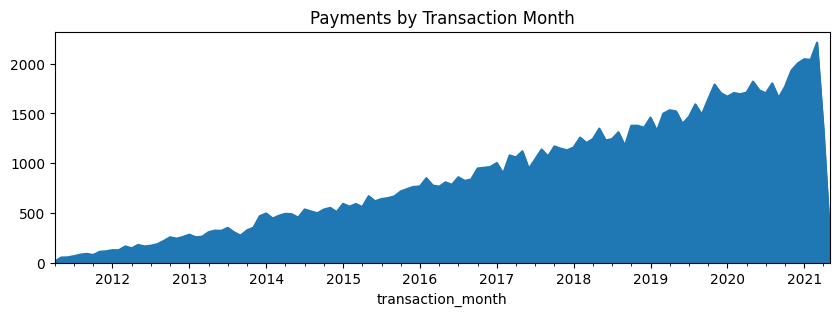

In [15]:
payments.__len__()
payments['transaction_month'] = payments.transaction_date.dt.to_period('M').dt.to_timestamp()
payments.groupby("transaction_month").invoice_id.nunique()\
.plot(kind='area', title="Payments by Transaction Month", figsize=figsize)

In [16]:
last_transaction_month = payments.transaction_month.max()
first_transaction_month = payments.transaction_month.min()
first_transaction_month, last_transaction_month

(Timestamp('2011-04-01 00:00:00'), Timestamp('2021-05-01 00:00:00'))

In [17]:
#converted_amount is reliable
(((payments.amount * payments.root_exchange_rate_value) - payments.converted_amount).abs()).max()

1.0913936421275139e-11

In [18]:
payments[payments.amount.isnull()!=payments.converted_amount.isnull()].__len__()

0

array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'converted_amount'}>]], dtype=object)

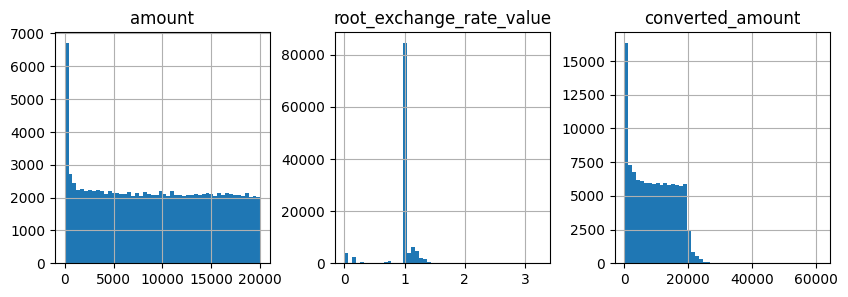

In [19]:
payments.select_dtypes(include='float').hist(bins=50, figsize=figsize, layout=(1,3))

### Invoices

Must become active within the date range of the transactions data to ensure completeness.

In [20]:
invoices_stats = invoices.describe(include='all')
invoices_stats.loc['% populated'] = invoices_stats.loc['count']/invoices.__len__()
invoices_stats

,invoice_id,due_date,invoice_date,status,amount_inv,currency,company_id,customer_id,account_id,cleared_date,root_exchange_rate_value
count,113085,113060,113085,113085,"113,085.0000",113085,113085,113085,113085,113085,"113,085.0000"
unique,113085,NaN,NaN,2,NaN,18,2,5055,2,NaN,NaN
top,0,NaN,NaN,CLEARED,NaN,USD,114,5,0,NaN,NaN
freq,1,NaN,NaN,109382,NaN,85146,109846,1788,109846,NaN,NaN
mean,NaN,2018-03-29 16:57:41.553157632,2018-02-21 19:27:25.236768512,NaN,"10,026.5999",NaN,NaN,NaN,NaN,2018-04-26 08:37:46.868284672,0.9708
min,NaN,2010-09-07 00:00:00,2010-12-21 00:00:00,NaN,0.0276,NaN,NaN,NaN,NaN,2011-04-13 00:00:00,0.0008
25%,NaN,2016-08-26 00:00:00,2016-07-21 00:00:00,NaN,"5,030.1226",NaN,NaN,NaN,NaN,2016-09-15 00:00:00,1.0000
50%,NaN,2018-09-22 00:00:00,2018-08-19 00:00:00,NaN,"10,018.0927",NaN,NaN,NaN,NaN,2018-10-13 00:00:00,1.0000
75%,NaN,2020-03-22 00:00:00,2020-02-17 00:00:00,NaN,"15,029.6856",NaN,NaN,NaN,NaN,2020-04-21 00:00:00,1.0000
max,NaN,2023-01-31 00:00:00,2023-01-01 00:00:00,NaN,"19,999.9749",NaN,NaN,NaN,NaN,2022-01-01 00:00:00,1.6816


<Axes: title={'center': 'Invoices by Invoice Month'}, xlabel='invoice_month'>

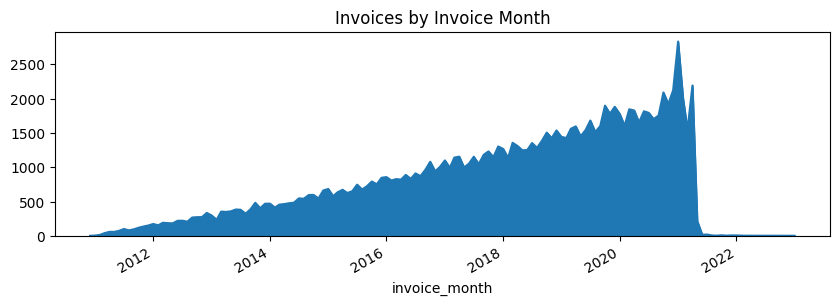

In [21]:
invoices['invoice_month'] = invoices.invoice_date.dt.to_period('M').dt.to_timestamp()
invoices['due_month'] = invoices.due_date.dt.to_period('M').dt.to_timestamp()
invoices.groupby("invoice_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Invoice Month", figsize=figsize)

<Axes: title={'center': 'Invoices by Due Month'}, xlabel='due_month'>

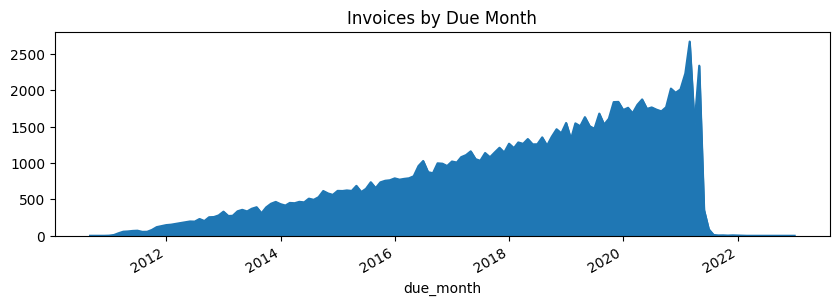

In [22]:
invoices.groupby("due_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Due Month", figsize=figsize)

In [104]:
#opened outside of payment data time period or after they were due - need to filter 
(invoices.loc[invoices.invoice_month>last_transaction_month].__len__(), 
invoices.loc[invoices.invoice_month<first_transaction_month].__len__(), 
invoices.loc[invoices.invoice_month.dt.to_period('M')>invoices.due_month.dt.to_period('M')].__len__())

(0, 0, 0)

In [106]:
invoices = invoices.loc[(invoices.invoice_month>=first_transaction_month) &
                        (invoices.invoice_month<=last_transaction_month) & 
                        (invoices.invoice_month<=invoices.due_date.dt.to_period('M').dt.to_timestamp())].copy()

In [25]:
#to compare to payments. Are we holding the customer accountable to USD or their own currency?
invoices['converted_amount_inv'] = invoices.amount_inv * invoices.root_exchange_rate_value

In [26]:
invoices['months_allowed'] = invoices.due_month.dt.to_period('M') - invoices.invoice_month.dt.to_period('M')
invoices.months_allowed = invoices.months_allowed.map(lambda m: m.n if not pandas.isnull(m) else None)
#almost all invoices are due immediately or within 3 months. filter out the rest
invoices.months_allowed.value_counts(normalize=True, dropna=False)

TypeError: unsupported Type Index

In [27]:
invoices['months_billing'] = invoices.cleared_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M')
invoices.months_billing = invoices.months_billing.map(lambda m: m.n if not pandas.isnull(m) else None)
#almost all invoices are cleared within a year. filter out ones that cleared before they opened. will clip to 12.  
invoices.months_billing.value_counts(normalize=True, dropna=False)

months_billing
 1    0.4507
 2    0.2655
 3    0.0810
 0    0.0718
 4    0.0324
 9    0.0213
 5    0.0186
 6    0.0116
 10   0.0086
 7    0.0083
 8    0.0082
 12   0.0067
 11   0.0045
-1    0.0016
 13   0.0015
 14   0.0012
 15   0.0009
 16   0.0006
-2    0.0006
 17   0.0005
-4    0.0004
 18   0.0004
-3    0.0004
 19   0.0003
 20   0.0002
 21   0.0002
-5    0.0002
 24   0.0001
 22   0.0001
 25   0.0001
 23   0.0001
 26   0.0001
 28   0.0001
-7    0.0001
-11   0.0001
-10   0.0001
-9    0.0001
 31   0.0001
 27   0.0001
-6    0.0001
-8    0.0001
 30   0.0001
 29   0.0001
 32   0.0001
-13   0.0000
-15   0.0000
-16   0.0000
-14   0.0000
-12   0.0000
-22   0.0000
-17   0.0000
 34   0.0000
-18   0.0000
 40   0.0000
 38   0.0000
-21   0.0000
-32   0.0000
-19   0.0000
 36   0.0000
 35   0.0000
Name: proportion, dtype: float64

### Exchange Rate

Exchange rates vary for both payments and open invoices. Customers would expect to pay the amount they were originally invoiced in their own currency, not the USD amount originally invoiced. Therefore, we should use raw amounts to determine how much is paid vs due. 

<Axes: title={'center': 'Exchange Rate Spread Ratio'}, xlabel='currency'>

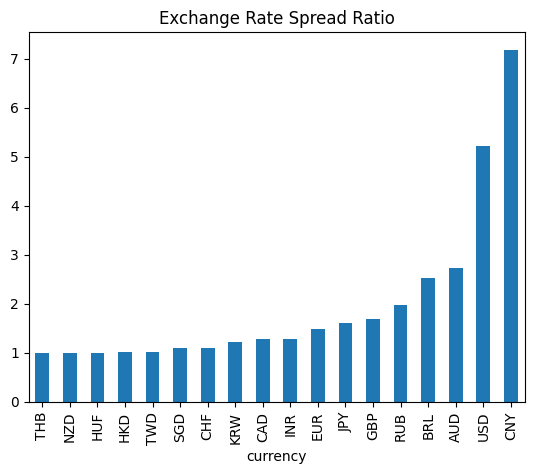

In [28]:
# USD is not is always 1 - it varies a lot
currency_ranges = invoices.groupby("currency").root_exchange_rate_value.describe(percentiles=[])
(currency_ranges['max']/currency_ranges['min']).sort_values().plot(kind='bar', title="Exchange Rate Spread Ratio")

In [29]:
# 1.6% of USD invoices have an exchange rate unequal to 1
invoices_usd = invoices.query("currency=='USD'").copy()
invoices_usd['exchange_rate_is_1'] = invoices_usd['root_exchange_rate_value'] == 1
1 - invoices_usd.exchange_rate_is_1.mean()

0.015620037873886994

In [30]:
# USD exchange rate variations from 1 tend to be invoices which took longer to clear
# This suggests that the invoice exchange rate is "current state data." 
time_to_clear = invoices_usd.cleared_date - invoices_usd.invoice_date
invoices_usd['months_to_clear'] = time_to_clear.map(lambda t: round(t.days/30))

In [31]:
invoices_usd.groupby("exchange_rate_is_1").months_to_clear.agg(['mean','count'])

,mean,count
exchange_rate_is_1,,
False,2.9209,1328
True,1.8942,83691


<Axes: title={'center': '% of USD Invoices With Exchange Rate Equal to 1'}, xlabel='months_to_clear'>

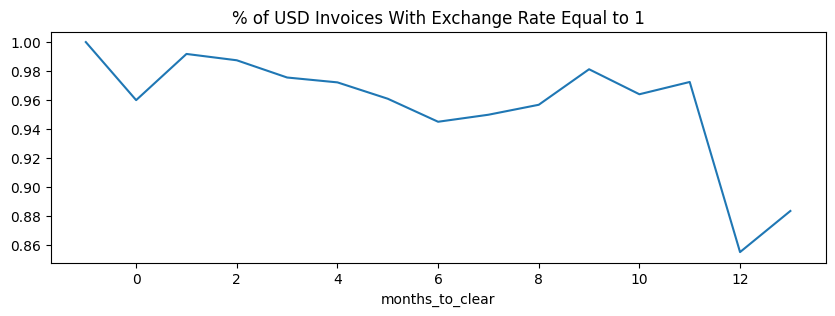

In [32]:
invoices_usd.groupby(invoices_usd.months_to_clear.clip(upper=13, lower=-1))\
.exchange_rate_is_1.mean().plot(title='% of USD Invoices With Exchange Rate Equal to 1', figsize=figsize)

### Invoice status vs cleared date

All invoices have a date cleared. 
When an invoice is open, the date cleared is set to the future, and seems to be an assumed value. 

In [33]:
invoices.loc[invoices.cleared_date.isnull()].__len__()

0

In [34]:
invoices.status.value_counts(normalize=True, dropna=False).to_frame(name="% of Invoices")

,% of Invoices
status,
CLEARED,0.9679
OPEN,0.0321


In [35]:
invoices.loc[invoices.cleared_date.isnull() != (invoices.status == 'OPEN'),['status','cleared_date']]\
.value_counts(dropna=False)

status  cleared_date
OPEN    2022-01-01      3628
Name: count, dtype: int64

In [36]:
#all open invoices have the same cleared date, which is in the future relative to the latest transaction
invoices.loc[invoices.status == 'OPEN'].cleared_date.value_counts(dropna=False)

cleared_date
2022-01-01    3628
Name: count, dtype: int64

In [37]:
#all cleared invoices have a cleared date within the payments data window
invoices.loc[invoices.status == 'CLEARED', ['invoice_date','cleared_date']].agg(['min','max'])

,invoice_date,cleared_date
min,2011-04-02,2011-04-24
max,2021-05-12,2021-05-18


In [38]:
#open invoices are already active
invoices.loc[invoices.status == 'OPEN', ['invoice_date','due_date']].agg(['min','max'])

,invoice_date,due_date
min,2019-06-27,2019-08-31
max,2021-05-31,2021-08-29


### Merging & Checking for Consistency

- No individual payments are more than their invoices. 
- Exchange rates vary across payments.
- Companies are consistent between payments and invoices, when payments are present. 
- Amounts make the most sense in their original currencies vs in USD

In [39]:

invoice_payments = invoices.rename(columns={"amount_inv":"amount","converted_amount_inv":"converted_amount"})\
.merge(payments, on="invoice_id", how='left', suffixes=('_inv', '_pmt'))

In [40]:
invoice_payments.invoice_id.nunique()

112913

In [41]:
duplicated_columns = [col.replace('_pmt','') for col in invoice_payments.columns if col.endswith('_pmt')]
for col in  duplicated_columns:
    inconsistent_rows = invoice_payments.loc[invoice_payments[col + '_pmt']!=invoice_payments[col + '_inv']]
    print(f"{col}: {inconsistent_rows.__len__()/invoice_payments.__len__()} inconsistent rows in merged dataset")

amount: 0.18239483175591428 inconsistent rows in merged dataset
root_exchange_rate_value: 0.3063540280671805 inconsistent rows in merged dataset
company_id: 0.06677880149624683 inconsistent rows in merged dataset
converted_amount: 0.38632122444539285 inconsistent rows in merged dataset


In [42]:
invoice_payments.query("company_id_pmt!=company_id_inv").company_id_pmt.value_counts(dropna=False)

company_id_pmt
NaN    7980
Name: count, dtype: int64

In [43]:
invoice_payments.query("amount_pmt!=amount_inv")[['amount_pmt','amount_inv']].describe()

,amount_pmt,amount_inv
count,"13,815.0000","21,796.0000"
mean,"5,018.7732","9,963.6640"
std,"5,889.9415","5,769.2289"
min,0.0000,2.2108
25%,94.5230,"4,944.9051"
50%,"2,088.1897","9,940.7486"
75%,"9,184.1173","14,931.6609"
max,"19,989.9866","19,999.9749"


In [44]:
#no payment is more than the invoice amount in the original currency
invoice_payments.loc[invoice_payments.amount_pmt>invoice_payments.amount_inv].__len__()

0

In [45]:
#converting to USD creates payments that are higher than invoice totals
invoice_payments.loc[invoice_payments.converted_amount_pmt>invoice_payments.converted_amount_inv].__len__()

11061

### Business Questions for the Data

In [46]:
invoice_payments['amount_pmt_pct'] = (invoice_payments.amount_pmt/invoice_payments.amount_inv)

In [47]:
# Rougly 12% of payments are partial
(invoice_payments.amount_pmt_pct.dropna()<1).mean()

0.12388134650908374

<Axes: title={'center': '% of Invoice Collected with Payment'}, ylabel='Frequency'>

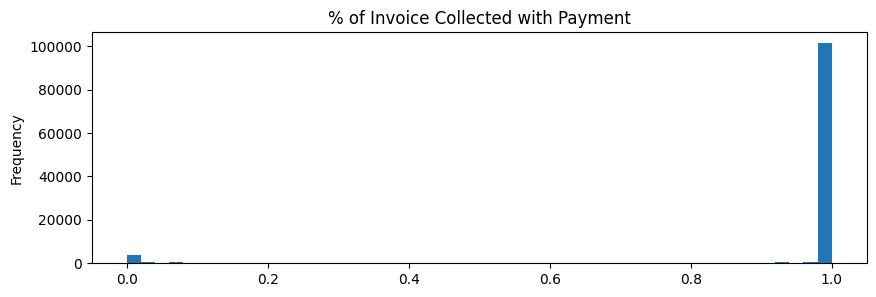

In [48]:
invoice_payments.amount_pmt_pct\
.plot(kind="hist",bins=50, title="% of Invoice Collected with Payment", figsize=figsize)

In [49]:
invoice_payments.sort_values(by=['invoice_id','transaction_date'], inplace=True)

<Axes: title={'center': 'Summed % of Invoice Collected with Payment'}, ylabel='Frequency'>

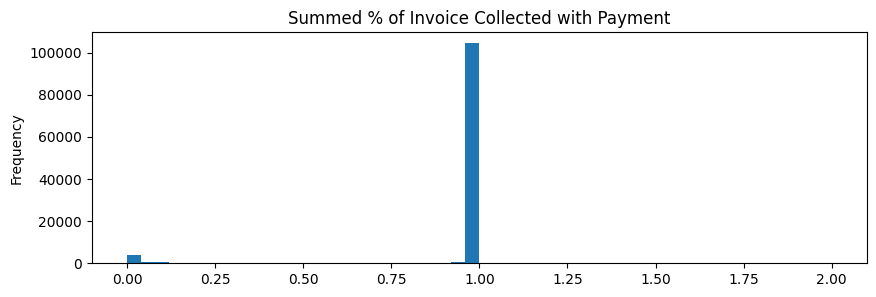

In [50]:
invoice_payments.groupby("invoice_id").amount_pmt_pct.cumsum()\
.plot(kind="hist",bins=50, title="Summed % of Invoice Collected with Payment", figsize=figsize)

In [51]:
#small percent of payments represent overpayments
invoice_payments['pmt_pct_cum'] = invoice_payments.groupby("invoice_id").amount_pmt_pct.cumsum()
(invoice_payments.pmt_pct_cum>1).mean()

0.006661143607896301

In [52]:
#invoices with no transactions: use payments data end date as date of 0 amount 
invoice_payments.transaction_month = invoice_payments.transaction_month.fillna(last_transaction_month)

In [53]:
#there can be multiple transactions per month
invoice_payments.groupby(["invoice_id","transaction_month"]).transaction_month\
.count().value_counts(normalize=True).head()

transaction_month
1   0.9539
2   0.0446
3   0.0013
4   0.0002
5   0.0000
Name: proportion, dtype: float64

In [54]:
#the transactions are not duplicates
invoice_payments.groupby(["invoice_id","transaction_month"]).amount_pmt\
.nunique().value_counts(normalize=True).head()

amount_pmt
1   0.8843
0   0.0700
2   0.0444
3   0.0012
4   0.0001
Name: proportion, dtype: float64

In [55]:
#but they are almost always on the same day
invoice_payments.groupby(["invoice_id","transaction_month"]).transaction_date.nunique()\
.value_counts(normalize=True).head()

transaction_date
1   0.9269
0   0.0700
2   0.0030
3   0.0001
Name: proportion, dtype: float64

In [56]:
payment_totals = invoices.set_index('invoice_id')
payment_totals['pmt_pct_cum'] = invoice_payments.groupby("invoice_id").pmt_pct_cum.max().fillna(0)
payment_totals['transaction_month_max'] = invoice_payments.groupby("invoice_id").transaction_month.max()
payment_totals['collected_month'] = invoice_payments.query("pmt_pct_cum>=1")\
.groupby("invoice_id").transaction_month.min()
payment_totals.reset_index(inplace=True, names=['invoice_id']) 

#### Comparing invoice status and % collected 

- Invoices with cleared status can still have amounts remaining. 
- Invoices with open status are rarely collected. 

In [57]:
# define invoice as collected if payments meet invoice amount in original currencies. 91% are collected
payment_totals['collected'] = payment_totals.collected_month.isnull()==False
payment_totals.collected.mean()

0.9051924933355769

In [58]:
#define cleared based on status. 97% are cleared
payment_totals['cleared'] = payment_totals.status=='CLEARED'
payment_totals.cleared.mean()

0.9678690673350279

In [59]:
#6% of invoices have a mismatch between collected and cleared 
(payment_totals.collected!=payment_totals.cleared).mean()

0.06271199950404294

In [60]:
#on average, 94% of cleared invoices are fully collected, compared to <1% of open ones
#cleared invoices have 96% of their amounts collected on average
payment_totals.groupby("status", as_index=False)[['collected','pmt_pct_cum']].mean()

,status,collected,pmt_pct_cum
0,CLEARED,0.9352,0.9573
1,OPEN,0.0006,0.0063


In [61]:
#67% of invoices that have not been collected are cleared nonetheless 
payment_totals.groupby("collected", as_index=False).cleared.mean()

,collected,cleared
0,False,0.6613
1,True,1.0000


#### Cleared Invoices

Cleared invoices may or may not be collected. If not collected, cleared invoices tend to be much more overdue, suggesting that invoices must be cleared at some point.

In [62]:
cleared_invoices = payment_totals.query("cleared == True").copy()
cleared_invoices['months_late'] = \
(cleared_invoices.collected_month.fillna(cleared_invoices.transaction_month_max).dt.to_period('M')\
- cleared_invoices.due_month.dt.to_period('M')).map(lambda m: m.n if not pandas.isnull(m) else None)

In [63]:
cleared_invoices.groupby("collected").months_late.agg(['mean','min','max'])

,mean,min,max
collected,,,
False,26.3719,-34,118
True,0.5463,-23,28


#### Comparing date cleared to date collected

Rarely, there can be a delay between the date an invoice is collected to when it is cleared. We will only forecast invoices when they are open AND not collected. 

In [64]:
payment_totals['clear_delay_months'] = (payment_totals.cleared_date.dt.to_period('M') \
- payment_totals.collected_month.dt.to_period('M')).map(lambda m: m.n if not pandas.isnull(m) else None)

In [65]:
payment_totals.__len__()

112913

In [66]:
payment_totals.clear_delay_months.describe(percentiles=[0.001,0.999])

count   102,208.0000
mean          0.1623
std           1.3627
min          -1.0000
0.1%          0.0000
50%           0.0000
99.9%        20.0000
max          39.0000
Name: clear_delay_months, dtype: float64

# Structuring Data for Business Problem

- The model will handle OPEN invoices and classify how many months in the future they will be collected. 
- Define an invoice as open between its invoice date and date cleared or collected, whichever is first. 

## Creating transaction periods to model historical invoices

To model the data, we have to look the invoices in each prior period they were open and calculate when they are collected relative to that time. 

To ensure completeness, the periods we use for modeling must fall within the date range of the transactions data. Since we will forecast a year in advance, the forecast period must also be at a year prior to when the transactions data ends, keeping in mind that the last month of transactions is incomplete. 

In [67]:
import random
def forecast_periods(invoice_month, last_billing_date):
    period_start = max(invoice_month,first_transaction_month.to_period('M'))
    period_end = min(last_billing_date,(last_transaction_month - pandas.DateOffset(months=13)).to_period('M'))
    period_range = pandas.period_range(period_start, period_end)
    if len(period_range)==0:
        return None
    return random.choice(period_range)

payment_totals['last_forecast_date'] = payment_totals[['cleared_date','collected_month']].min(axis=1)
payment_totals['forecast_month'] = numpy.vectorize(forecast_periods)\
(payment_totals.invoice_month.dt.to_period('M'), payment_totals.last_forecast_date.dt.to_period('M'))
payment_totals.forecast_month.agg(['min','max'])

min    2011-04
max    2020-04
Name: forecast_month, dtype: period[M]

## Live test cases: current open invoices

Invoices that we will predict after creating the model, without knowing the accuracy of the predictions. 
Per the instructions, we only predict collection dates for open invoices. 

Use the day after the payments data ends as the present date. 

In [68]:
present_month = last_transaction_month + pandas.DateOffset(months=1)
open_invoices = invoices.query("status=='OPEN'").copy()
open_invoices['forecast_month'] = present_month.to_period('M')

In [69]:
open_invoices[["forecast_month","invoice_month"]].agg(['min','max','count'])

,forecast_month,invoice_month
min,2021-06,2019-06-01 00:00:00
max,2021-06,2021-05-01 00:00:00
count,3628,3628


## Process inputs for model training and predictions

Normalizing by company:
Tesorio's pricing model is subscription, so Tesorio's revenue will be loosely based on paying customers per period. 
Normalizing amounts by company means each company will be of equal value each month they retain with Tesorio, regardless of their total cash flow. 

In [70]:
def process_model_inputs(invoices_at_time_periods):
    raw_input_columns = ['invoice_id','invoice_month','forecast_month','due_month',
                         'months_allowed','amount_inv', 'converted_amount_inv',
                         'currency','company_id','customer_id']
    output_col = 'collected_month'
    if output_col in invoices_at_time_periods.columns:
        raw_input_columns += [output_col, 'cleared_date']
    output_df = invoices_at_time_periods[raw_input_columns]
    #remove months_allowed > 3
    output_df = output_df[output_df.months_allowed.between(0,3)]
    #only forecast when the invoice is active. 
    output_df = output_df[output_df.forecast_month>=output_df.invoice_month.dt.to_period('M')]
    #normalize by company
    totals_by_company = output_df.groupby("company_id", as_index=False).converted_amount_inv.sum()
    output_df = output_df.merge(totals_by_company,on="company_id", suffixes=('','_company'))
    inv_pct_of_company_total = output_df.converted_amount_inv/output_df.converted_amount_inv_company
    output_df['inv_pct_of_company_total'] = inv_pct_of_company_total
    output_df.drop(columns=["converted_amount_inv"], inplace=True)
    #date quantities
    output_df['month_billing'] = (output_df.forecast_month \
                                  - output_df.invoice_month.dt.to_period('M')).map(lambda m: m.n+1).clip(upper=13, lower=1)
    output_df['month_due'] = (output_df.due_month.dt.to_period('M') \
                                  - output_df.forecast_month).map(lambda m: m.n+1).clip(upper=13, lower=1)
    output_df.forecast_month = output_df.forecast_month.dt.to_timestamp()
    return output_df

open_invoices_to_score = process_model_inputs(open_invoices)
invoices_to_model = process_model_inputs(payment_totals)

In [71]:
open_invoices_to_score.describe(include='all', percentiles=[0.001,0.999]).T

,count,unique,top,freq,mean,min,0.1%,50%,99.9%,max,std
invoice_id,3615,3615,12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_month,3615,NaN,NaN,NaN,2021-03-06 15:24:08.962655744,2019-06-01 00:00:00,2020-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-05-01 00:00:00,NaN
forecast_month,3615,NaN,NaN,NaN,2021-05-31 23:59:59.999999744,2021-06-01 00:00:00,2021-06-01 00:00:00,2021-06-01 00:00:00,2021-06-01 00:00:00,2021-06-01 00:00:00,NaN
due_month,3615,NaN,NaN,NaN,2021-04-15 11:37:53.526970880,2019-08-01 00:00:00,2020-05-20 00:48:57.600000,2021-05-01 00:00:00,2021-07-01 00:00:00,2021-07-01 00:00:00,NaN
months_allowed,"3,615.0000",NaN,NaN,NaN,1.3259,0.0000,0.0000,1.0000,3.0000,3.0000,0.6451
amount_inv,"3,615.0000",NaN,NaN,NaN,"10,004.6636",2.2108,9.2204,"9,925.4947","19,981.8147","19,989.6533","5,764.6267"
currency,3615,11,USD,2837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_id,3615,2,114,3568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,3615,1153,105,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted_amount_inv_company,"3,615.0000",NaN,NaN,NaN,"34,354,885.0573","527,349.8488","527,349.8488","34,800,483.1949","34,800,483.1949","34,800,483.1949","3,882,995.9499"


## Selecting prediction target

Predict collection relative to forecast date. 

Normalization:
- If the invoice isn't collected within the payments data time period, assume it's collected the day after, which we are using as the present date. 
- Clip collection period to 13 months, which is outside the forecast window.
- Calculate collection period using billing period as the unit.
- Invert to create % collected per billing period.

<Axes: title={'center': 'Month Collected Relative to Forecast Date'}, ylabel='Frequency'>

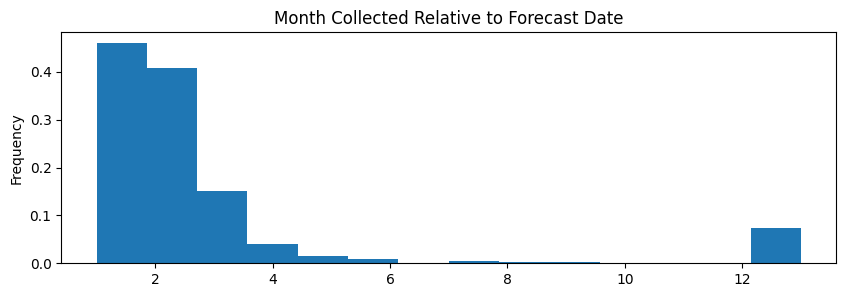

In [72]:
invoices_to_model['month_collected'] = (invoices_to_model.collected_month.fillna(present_month).dt.to_period('M')
    - invoices_to_model.forecast_month.dt.to_period('M')).map(lambda m: int(m.n+1)).clip(upper=13)
invoices_to_model.month_collected.plot(kind='hist', bins=14, figsize=figsize, 
title="Month Collected Relative to Forecast Date", density=True)

<Axes: title={'center': 'Average % Collected Per Month'}, ylabel='Frequency'>

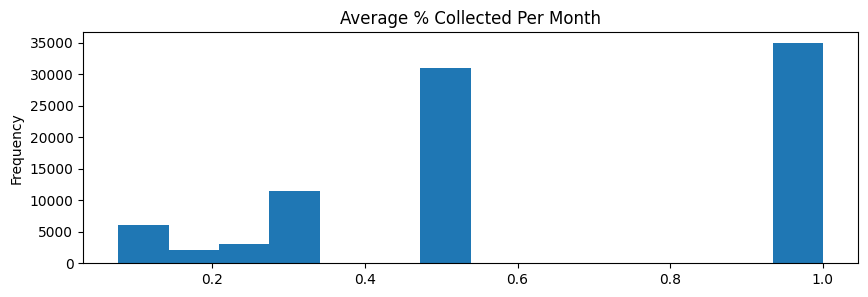

In [73]:
invoices_to_model['collected_per_month'] = 1/invoices_to_model.month_collected
invoices_to_model.collected_per_month\
.plot(kind='hist', bins=14, figsize=figsize, title="Average % Collected Per Month")

<Axes: title={'center': 'Average % Due Per Month'}, ylabel='Frequency'>

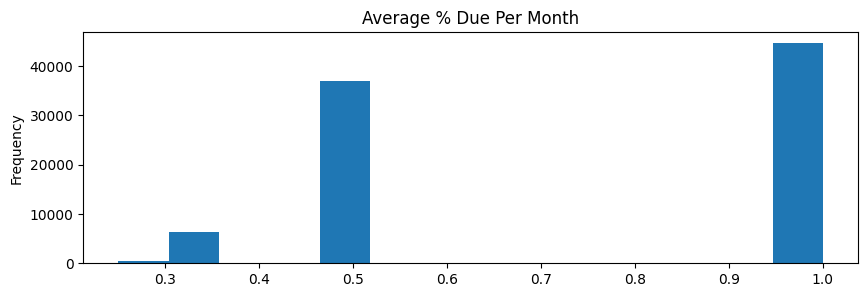

In [74]:
invoices_to_model['due_per_month'] = 1/invoices_to_model.month_due
invoices_to_model.due_per_month\
.plot(kind='hist', bins=14, figsize=figsize, title="Average % Due Per Month")

In [75]:
invoices_to_model.drop(columns=['cleared_date'], inplace=True, errors='ignore')
invoices_to_model.describe(include='all', percentiles=[0.001,0.999]).T

,count,unique,top,freq,mean,min,0.1%,50%,99.9%,max,std
invoice_id,88615,88615,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_month,88615,NaN,NaN,NaN,2017-05-21 02:17:56.810923520,2011-04-01 00:00:00,2011-05-01 00:00:00,2017-11-01 00:00:00,2020-04-01 00:00:00,2020-04-01 00:00:00,NaN
forecast_month,88615,NaN,NaN,NaN,2017-06-17 00:37:32.259775488,2011-04-01 00:00:00,2011-06-01 00:00:00,2017-12-01 00:00:00,2020-04-01 00:00:00,2020-04-01 00:00:00,NaN
due_month,88615,NaN,NaN,NaN,2017-06-26 08:18:32.154827264,2011-04-01 00:00:00,2011-05-01 00:00:00,2017-12-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,NaN
months_allowed,"88,615.0000",NaN,NaN,NaN,1.1910,0.0000,0.0000,1.0000,3.0000,3.0000,0.5011
amount_inv,"88,615.0000",NaN,NaN,NaN,"10,028.9255",0.3583,22.0021,"10,032.9086","19,978.3454","19,999.9749","5,771.9138"
currency,88615,17,USD,66319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_id,88615,2,114,85821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,88615,4292,5,1617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collected_month,83102,NaN,NaN,NaN,2017-07-24 22:57:13.217010176,2011-04-01 00:00:00,2011-07-01 00:00:00,2018-01-01 00:00:00,2020-09-01 00:00:00,2021-03-01 00:00:00,NaN


## Analyze Input Data

In [76]:
invoices_to_model['uncollected'] = invoices_to_model.collected_month.isnull()

### By Dates

<Axes: title={'center': 'Invoices by Forecast Month'}, xlabel='forecast_month'>

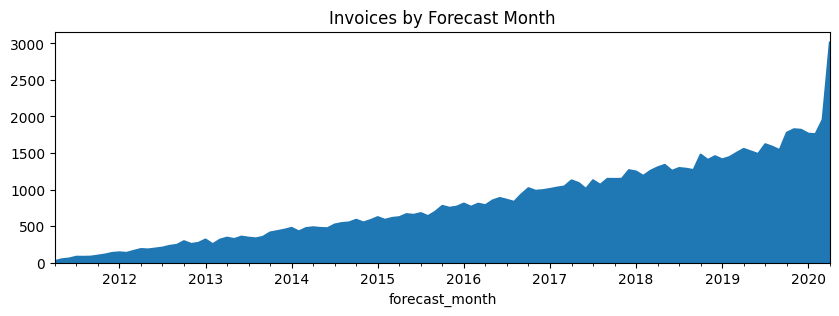

In [77]:
invoices_to_model.groupby("forecast_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Forecast Month", figsize=figsize)

<Axes: title={'center': 'Invoices by Invoice Month'}, xlabel='invoice_month'>

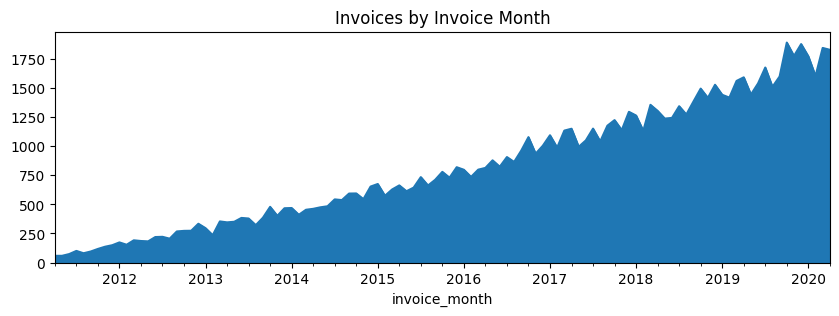

In [78]:
invoices_to_model.groupby("invoice_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Invoice Month", figsize=figsize)

<Axes: title={'center': 'Invoices by Due Month'}, xlabel='due_month'>

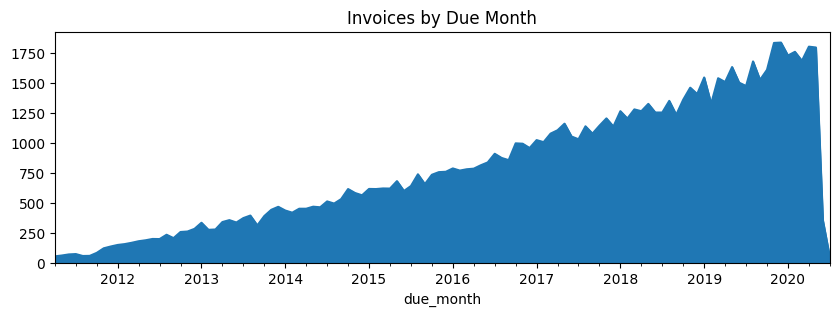

In [79]:
invoices_to_model.groupby("due_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Due Month", figsize=figsize)

### By Currency

Some currencies have very low collection rates and take multiple billing periods to collect. This may be due to currency fluctuations.

In [80]:
invoices_to_model.groupby("currency")\
.agg({"collected_per_month":["mean","std"],"invoice_id":"count","uncollected":"mean"})\
.sort_values(by=('uncollected','mean'), ascending=False)

collected_per_month        invoice_id uncollected
                        mean    std      count        mean
currency                                                  
TWD                   0.1266 0.1292         11      0.8182
HUF                   0.2051 0.1813          2      0.5000
HKD                   0.4038 0.3192          8      0.3750
INR                   0.4460 0.3654         83      0.3012
BRL                   0.5119 0.3556        463      0.2225
GBP                   0.6000 0.3503       1604      0.1353
KRW                   0.6343 0.3448         82      0.1341
SGD                   0.5192 0.3379        209      0.1292
CHF                   0.5905 0.3264         32      0.0938
CAD                   0.6282 0.3400         22      0.0909
EUR                   0.6072 0.3251      13698      0.0745
AUD                   0.5970 0.3284       1095      0.0694
CNY                   0.5680 0.3268       1907      0.0692
USD                   0.6383 0.3157      66319      0.0564
JPY                   0.6632 0.3065       3068      0.0476
NZD                   0.5000    NaN          1      0.0000
RUB                   0.6515 0.3432         11      0.0000

### Trends and Sparsity Over Time

Invoices are getting collected more quickly relative to their billing period, leading to a greater percentage collected over time - a good sign for Tesorio's business. 

<Axes: title={'center': 'Average Month Collected'}, xlabel='invoice_month'>

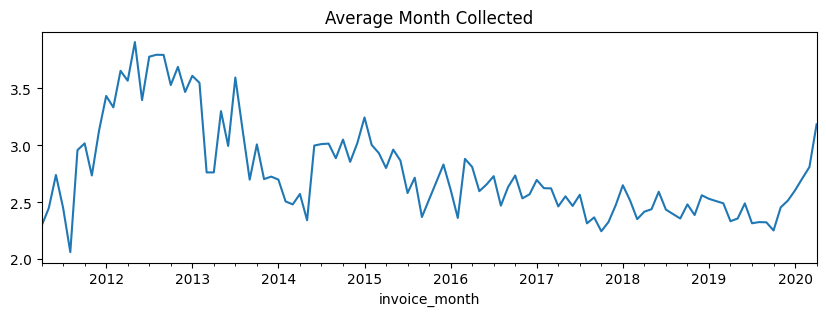

In [81]:
invoices_to_model.groupby("invoice_month").month_collected.mean()\
.plot(kind='line', title="Average Month Collected", figsize=figsize)

<Axes: title={'center': '% Invoices Uncollected by Invoice Month'}, xlabel='invoice_month'>

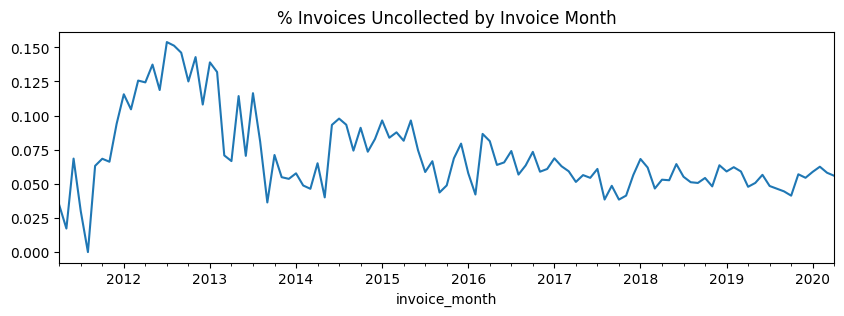

In [82]:
invoices_to_model.groupby("invoice_month").uncollected.mean()\
.plot(kind='line', title="% Invoices Uncollected by Invoice Month", figsize=figsize)

<Axes: title={'center': '% Invoices Uncollected by Due Month'}, xlabel='due_month'>

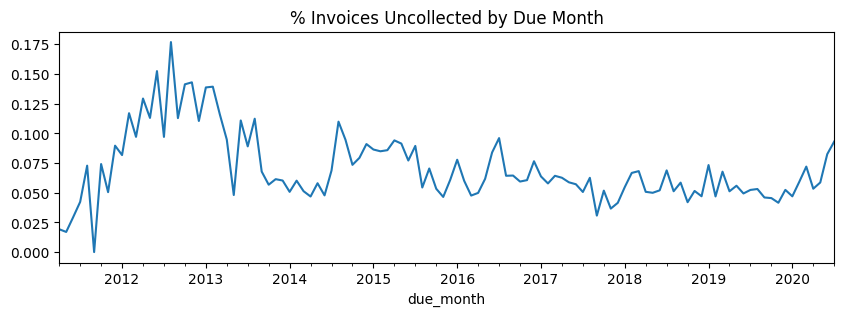

In [83]:
invoices_to_model.groupby("due_month").uncollected.mean()\
.plot(kind='line', title="% Invoices Uncollected by Due Month", figsize=figsize)

### By Customer 

We have trouble collecting from some customers, regardless of their currency. 

array([[<Axes: title={'center': 'months_allowed'}>,
        <Axes: title={'center': 'amount_inv'}>,
        <Axes: title={'center': 'converted_amount_inv_company'}>],
       [<Axes: title={'center': 'inv_pct_of_company_total'}>,
        <Axes: title={'center': 'month_billing'}>,
        <Axes: title={'center': 'month_due'}>],
       [<Axes: title={'center': 'month_collected'}>,
        <Axes: title={'center': 'collected_per_month'}>,
        <Axes: title={'center': 'due_per_month'}>],
       [<Axes: title={'center': 'uncollected'}>, <Axes: >, <Axes: >]],
      dtype=object)

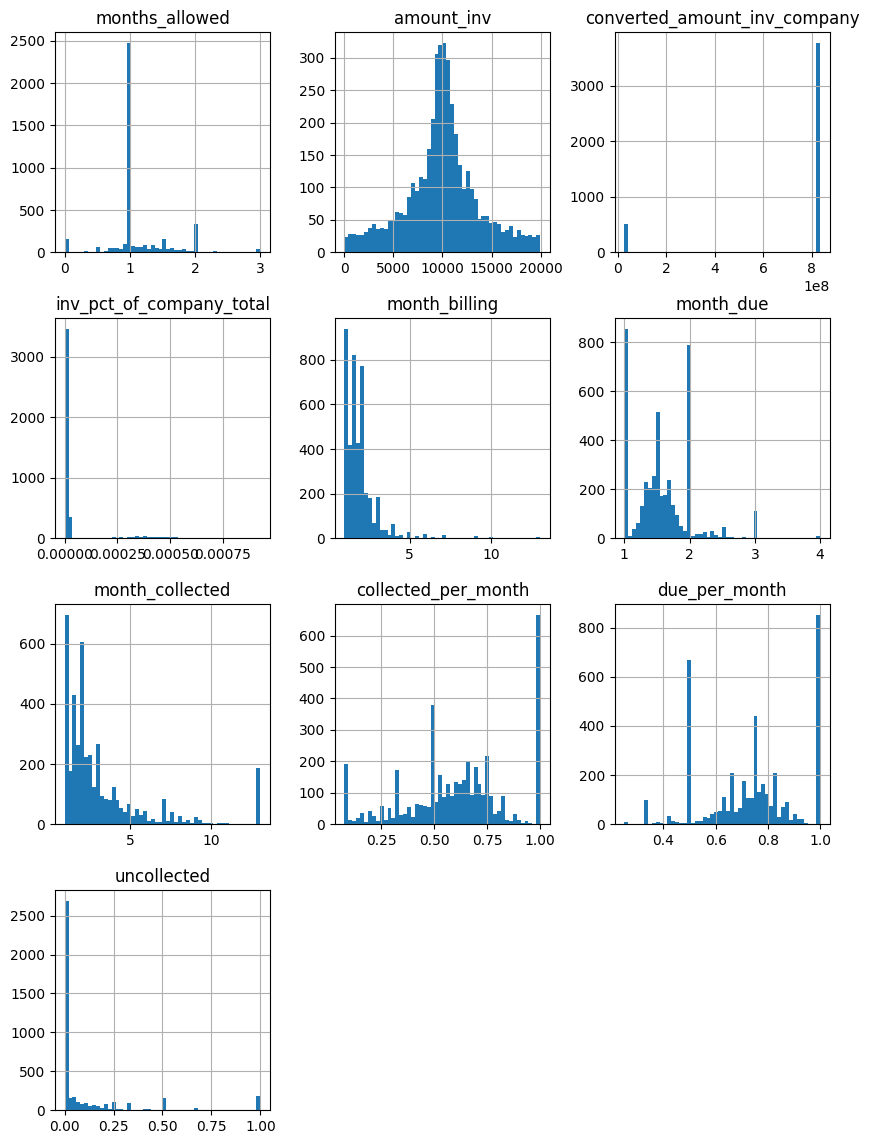

In [84]:
customer_averages = invoices_to_model.set_index("customer_id").select_dtypes(include=['float','int','boolean'])\
.reset_index().groupby("customer_id").mean()
customer_averages.hist(bins=50, figsize=(10,14), layout=(4,3))

<Axes: title={'center': 'Customers with 30+ Invoices: % Uncollected'}, ylabel='Frequency'>

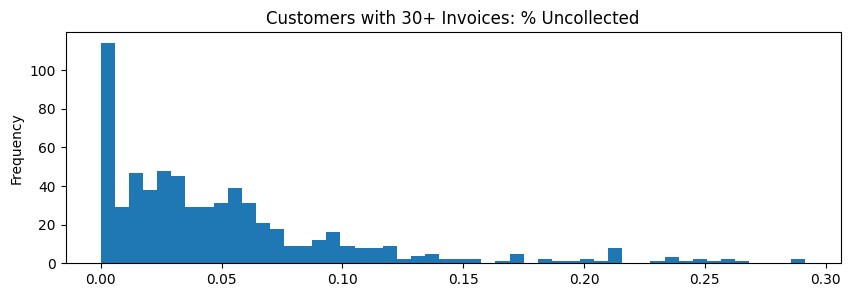

In [85]:
customer_stats = invoices_to_model.groupby("customer_id").uncollected.agg(['count','mean'])\
.add_prefix('uncollected_').sort_values(by="uncollected_mean", ascending=False)
customer_stats.query("uncollected_count>=30").uncollected_mean\
.plot(kind='hist', figsize=figsize, title="Customers with 30+ Invoices: % Uncollected", bins=50)

<Axes: title={'center': 'US and European Customers with 30+ Invoices: % Uncollected'}, ylabel='Frequency'>

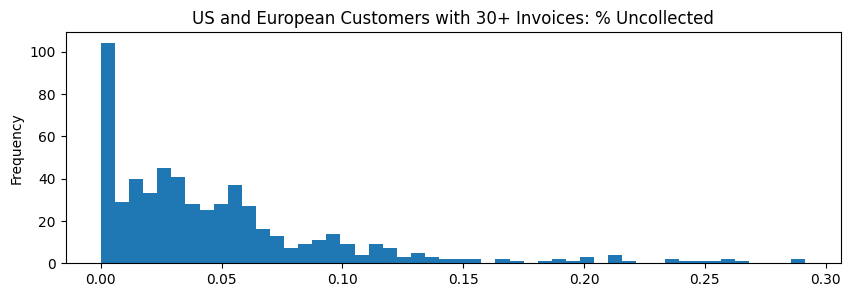

In [86]:
western_customer_stats = invoices_to_model.query("currency in ('USD','EUR','GBP')")\
.groupby("customer_id").uncollected.agg(['count','mean'])\
.add_prefix('uncollected_').sort_values(by="uncollected_mean", ascending=False)
western_customer_stats.query("uncollected_count>=30").uncollected_mean\
.plot(kind='hist', figsize=figsize, title="US and European Customers with 30+ Invoices: % Uncollected", bins=50)

# Business Analysis

## Business Motivation

Cash collections don't follow due dates. On average:

- 6% of total cash due each month is unpaid, equating to a \\$471K average deficit.
- Total cash collected each month is 10% off from the amount due, equating to a $571K average difference in cash flow. 

We also see that we need to filter out the first few month of due dates, which have unusually high differences.

In [87]:
amount_due = payment_totals.groupby("due_month").converted_amount_inv.sum().to_frame(name="amount_due_usd")
amount_paid = payments.rename(columns={"transaction_month":"due_month"})\
.groupby("due_month").converted_amount.sum().to_frame(name="amount_paid_usd")
business_motivation = amount_due.join(amount_paid, how='inner').reset_index(names='due_month')\
.query(f"due_month>='{first_transaction_month}' and due_month<'{last_transaction_month}'")
business_motivation['pct_unpaid'] = 1 - (business_motivation.amount_paid_usd/business_motivation.amount_due_usd)
business_motivation['unpaid'] = business_motivation.amount_due_usd - business_motivation.amount_paid_usd
business_motivation.set_index('due_month', inplace=True)

<Axes: title={'center': '% Unpaid (USD Due)'}, xlabel='due_month'>

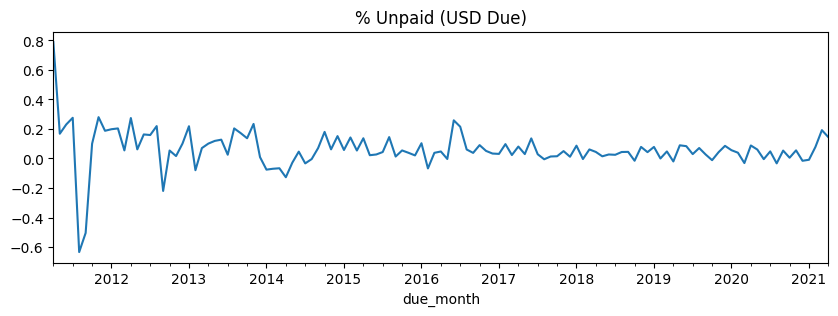

In [88]:
business_motivation.pct_unpaid.plot(figsize=figsize, title="% Unpaid (USD Due)")

In [89]:
business_motivation.pct_unpaid.mean(), business_motivation.pct_unpaid.abs().mean()

(0.0617378348667631, 0.09580762450258251)

In [90]:
business_motivation.unpaid.mean(), business_motivation.unpaid.abs().mean()

(471779.5255081043, 570446.6348510585)

In [91]:
invoices_to_model.query("due_month<'2011-10-01'").__len__()

361

## Data Science Benchmark

Companies will be more likely to retain if their monthly forecast error is low as a percentage of their total cash flow.

As a benchmark, we use due date in place of the forecast, filtering out the first few months, which have abnormally high errors rates. Weighting companies equally, on average, a company's monthly cash flow is 24% off from their cash due.

In [92]:
invoices_to_model = invoices_to_model.query("due_month>='2011-10-01'")

In [107]:
invoices_to_model.__len__(), invoices_to_model.inv_pct_of_company_total.sum()

(88254, 1.9951759969192067)

In [96]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(invoices_to_model.collected_per_month, invoices_to_model.due_per_month, 
                    sample_weight=invoices_to_model.inv_pct_of_company_total)

0.23538933421251826

## ML Task

Turning this into an ML task without any additional feature engineering, a company's average % difference from cash flow forecasted is reduced to 20%.

In [97]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

h2o:1: DeprecationWarning: Your Python version is 3.11.3. The support for this version will be removed in H2O 3.42.0.1.


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_65"; Java(TM) SE Runtime Environment (build 1.8.0_65-b17); Java HotSpot(TM) 64-Bit Server VM (build 25.65-b01, mixed mode)
  Starting server from /usr/local/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/x7/h_27fz_13f3dly9n_3wywqzc0000gn/T/tmpoxz0gv39
  JVM stdout: /var/folders/x7/h_27fz_13f3dly9n_3wywqzc0000gn/T/tmpoxz0gv39/h2o_lauren_started_from_python.out
  JVM stderr: /var/folders/x7/h_27fz_13f3dly9n_3wywqzc0000gn/T/tmpoxz0gv39/h2o_lauren_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_lauren_kx19f3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.67 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [98]:
#enables time-based split
invoices_to_model['forecast_date_fold']=(invoices_to_model.forecast_month.rank(pct=True)*6).round()
#invoice weight is based on the company-adjusted amount. unit is number of rows
invoices_to_model['inv_company_weight'] = invoices_to_model.inv_pct_of_company_total*invoices_to_model.invoice_id.nunique()\
/invoices_to_model.company_id.nunique()
invoices_to_model.inv_company_weight.sum(), invoices_to_model.__len__()

(88041.13121605382, 88254)

In [99]:
id_columns_h2o = [col for col in id_columns if col in invoices_to_model.columns]
invoices_to_model_h2o = h2o.H2OFrame(invoices_to_model,
           column_types=dict(zip(id_columns_h2o,["string"] * len(id_columns_h2o))))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [100]:
#time-based split: cross-validating on future data relative to what is being trained
train = invoices_to_model_h2o[invoices_to_model_h2o['forecast_date_fold'] <= 3]
blend = invoices_to_model_h2o[(invoices_to_model_h2o['forecast_date_fold'] > 3) \
                              & (invoices_to_model_h2o['forecast_date_fold'] <= 4)]
valid = invoices_to_model_h2o[invoices_to_model_h2o['forecast_date_fold'] > 4]

In [101]:
y_numeric='collected_per_month'
x = ['months_allowed','amount_inv','inv_pct_of_company_total','currency','month_billing','due_per_month']
#huber is a bi-modal distribution
#hyperparameter tuning is addressed by using AutoML and specifying sort and stopping metrics. 
#train, blend, and validation dataframes are binned sequentially by forecast month
#this enforces the time-based split during hyperparameter tuning. 
aml = H2OAutoML(max_runtime_secs=60, distribution='huber', sort_metric='mae', stopping_metric='mae', stopping_tolerance=0.01)
aml_model = aml.train(x=x , y=y_numeric, training_frame=train, blending_frame=blend, validation_frame=valid, 
                      weights_column='inv_company_weight') 

AutoML progress: |
21:17:47.350: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████
21:18:33.569: _weights_column param, All base models use weights_column="inv_company_weight" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

███████████████| (done) 100%


In [102]:
aml_model.mae(),aml_model.mae(valid=True)

(0.2011030915861319, 0.18920266651800888)

In [103]:
aml_model.r2(),aml_model.r2(valid=True)

(0.3199542576120642, 0.35091177206826973)